# Graphene quantum Hall effect

In [15]:
import kwant
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
# A COMMENT TO 
# git add .
# git commit -m "message"
# git push

## Fundamental constants

In [16]:
h = 6.626069e-34  # Planck constant (Js)
h_reduced=h/(2*np.pi)                            ##With h_reduced oom larger and Bmax=30, it works perfectly
## Scaling factor of 10 required --> h_reduced normal, Bmax=3
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

print(h_reduced)

1.0545716346179718e-34


### Scaling

In [17]:
asquare = 1e-9 # [m] a is the lattice parameter
tsquare = 1 # [eV] t is the hopping parameter

scaling = 4 # scaling factor

"""scaling"""

a = asquare * scaling
t = tsquare / scaling

### Geometrical parameters

In [48]:
W=200e-9 ; L = 1000e-9 # width and length of the electronic system

## For width smaller than 50 nm, the script does not work since the magnetic length is 30 nm so wf start to overlap (?)
## Also for width slightly larger than that, the steps in the Hall resistance are lost. For w=200 nm they are recovered.
length_lead=20e-9                                         
posL = 350e-9 # pos of the leads along x
lead_ext = posL + length_lead/2
lead_int = posL - length_lead/2

flag=0

#### Geometry of the device

In [49]:
def geom(pos):
    x, y = pos
    
    if -L/2 < x < L/2 and -W/2 < y < W/2:
        return True
    else:
        return False

#### Geometry of the leads

In [50]:
def lead_shape(pos):
    x, y = pos
    
    return -W/2 < y < W/2

def lead_shape_left(pos):
    x, y = pos
    
    return -lead_ext < x < -lead_int

def lead_shape_right(pos):
    x, y = pos
    
    return lead_ext > x > lead_int

#### Defining onsite and hopping parameters

In [51]:
def onsite(site):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential Vg (above the bottom of the conduction band) can be defined in a given zone 
    (square or circle here). 
    
    """
    x, y = site.pos
    
    #Theoretically we should insert the tip potential here (?)
    #For now we set Vg=0
    
    rho = np.sqrt(x**2 + y**2)
    
    in_shape_1 = abs(x) < l_pot_2 and y > -W/2 + w_pot
    in_shape_2 = abs(x) < l_pot_3 and y > -W/2 + w_pot
    
    if in_shape_1:
        
        pot=0 + Vg + delta + disorder(site)
        return pot
    
    if in_shape_2:
        
        pot=0 + Vg + 2*delta + disorder(site)
        return pot
    
    else:
        
        pot=0+disorder(site)
        return pot

#### Disorder potential

In [52]:
def disorder(pos):
    x, y = pos
    
   
    
    #pot=0.05*random.uniform(0,t)
    pot=0
    
    if (pot!=0):
        flag=1
        
    
    return pot

Introducing a disorder of 0.01 leads to peaks in longitudinal resistance but we retain anyway plateaus in Hall resistance.

#### Hopping parameter

In [53]:
def hopping(site_i, site_j):   
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    
    

    """ Change the definition of hop to include the magnetic field Bfield in the definition of the hopping parameter """
    
    hop = t*np.exp(-1j*e*Bfield*(yi+yj)*(xj-xi)/(2*h_reduced))  # to be completed (as a function of Bfield) #I think there is a - in the exponent
    
    
    #print('Hopping parameter is ',hop)
    
    return hop

## Building the system

In [54]:
def sys_builder():
    lat=kwant.lattice.honeycomb(a, norbs=1)
    
    sys=kwant.Builder()
    sys[lat.shape(geom, (0,0))]=onsite              #you assign to each site in lat.shape(geom, (0,0)) (all the lattice) the value onsite
    sys[lat.neighbors()]=hopping

    
    
  ### Schematic of the Hall bar ###

#   ,----------o----Vxx----.--------------.
#   |  Lead 3  |           |  Lead 5    __|__
#  Vxy     __|   |_______|   |__        '''''    (ground)
#   |               I
#   | Lead 1      ----->      Lead 2
#   |      __     _______     __
#   |        |   |       |   |
#   |  Lead 4  |               Lead 6
#   `----------'
    
    """ Lead 1 """
    sym0 = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
    lead0 = kwant.Builder(sym0)
    lead0[lat.shape(lead_shape, (0, 0))] = 0
    lead0[lat.neighbors()] = hopping

    """ Lead 2 """
    sym1 = kwant.TranslationalSymmetry(lat.vec((1, 0)))
    lead1 = kwant.Builder(sym1)
    lead1[lat.shape(lead_shape, (0, 0))] = 0    
    lead1[lat.neighbors()] = hopping

    """ Lead 3 """
    sym2 = kwant.TranslationalSymmetry(lat.vec((0, 1)))
    lead2 = kwant.Builder(sym2)
    lead2[lat.shape(lead_shape_left, (-posL, 0))] = 0
    lead2[lat.neighbors()] = hopping

    """ Lead 4 """
    sym3 = kwant.TranslationalSymmetry(lat.vec((0, -1)))
    lead3 = kwant.Builder(sym3)
    lead3[lat.shape(lead_shape_left, (-posL, 0))] = 0
    lead3[lat.neighbors()] = hopping

    """ Lead 5 """                             #sym already created with the correct symmetry, you just need to put the correct position
    lead4 = kwant.Builder(sym2)
    lead4[lat.shape(lead_shape_right, (posL, 0))] = 0
    lead4[lat.neighbors()] = hopping
    
    """Lead 6"""
    lead5 = kwant.Builder(sym3)
    lead5[lat.shape(lead_shape_right, (posL,0))] = 0
    lead5[lat.neighbors()]= hopping
    
    """ The leads are attached """
    sys.attach_lead(lead0)
    sys.attach_lead(lead1)
    sys.attach_lead(lead2)
    sys.attach_lead(lead3)
    sys.attach_lead(lead4)
    sys.attach_lead(lead5)
 
    sys = sys.finalized()
    
    
    
    return sys

    

In [55]:
sys= sys_builder()

#### Plotting the system

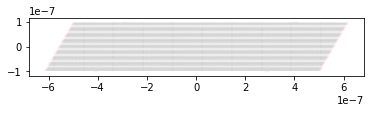

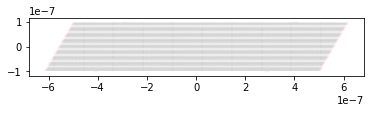

In [56]:
kwant.plot(sys, site_size = 1e-9)

## Electronic properties

In [57]:
Ef=-0.02 #maybe it could be modified
#Bfield=2*abs(Ef)**2*h_reduced/(9*t**2*a**2*e*0.2)   #The Fermi energy should be in between two LL
Bfield=1.82


""" Parameter for the zero density zone """  #these could be modified for the tip potential
Vg = -0.1
X_1=200e-9
X_2=300e-9
X_3=400e-9

l_pot=300e-9
l_pot_1=300e-9
l_pot_2=200e-9
l_pot_3=100e-9

delta=0.07
w_pot = 0


#print(Bfield)

params = dict(Bfield=Bfield, Vg = Vg) # params take the magnetic field as a parameter for the function hopping
print(params)



{'Bfield': 1.82, 'Vg': -0.1}


In [58]:
""" The wavelength must be (much more) larger than the lattice parameter """
""" We can also check the width of the device wrt the magnetic length, which is the extension of the wf"""
lambda_F = 3 * np.pi * t* a /abs(Ef) # computation of the wavelength
mag_length=np.sqrt(h_reduced/(e*Bfield))

print("lambda_F=", lambda_F);
print("l_b=", mag_length)

if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
#if lambda_F > W/2:
#    print('Warning : lambda_F larger than half width of the bar')
if mag_length > W/2:
    print('Warning : wavefunctions extend across the whole bar')

lambda_F= 4.71238898038469e-07
l_b= 1.9018273689526035e-08


#### Visualization of the Landau levels

LL n 0 = 0.0
LL n 1 = 0.11154116184204041
LL n 2 = 0.1577430238398659
LL n 3 = 0.19319495944567694
LL n 4 = 0.22308232368408082
Fermi Energy = -0.02


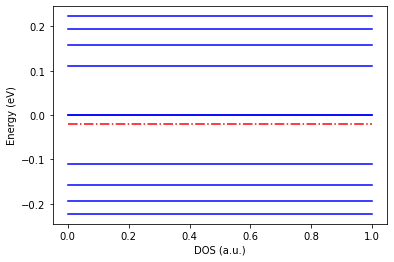

In [59]:
num_LL = 5

plt.figure()

for n in range(num_LL):
    
    """ 
    Change the definition of En to calculate the Landau levels energy as a function of
    the magnetic field Bfield and the Landau level label n
    
    """
    En_plus = 3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield) # to be completed
    En_minus = -3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield)
    
    x = np.array([0, 1]) ; 
    y_plus = En_plus*np.array([1, 1]) # in order to plot the Landau levels
    y_minus = En_minus*np.array([1, 1])
    plt.plot(x, y_plus, 'b')
    plt.plot(x, y_minus, 'b')
    
    print('LL n',n, '=',En_plus)
    
print ('Fermi Energy =',Ef)
    
plt.plot(x, Ef*np.array([1, 1]), 'r-.') # to plot the Fermi energy (in red)

plt.xlabel('DOS (a.u.)')
plt.ylabel('Energy (eV)')

plt.show()

#### Definition of the stairwell tip potential

Text(0, 0.5, 'Tip potential')

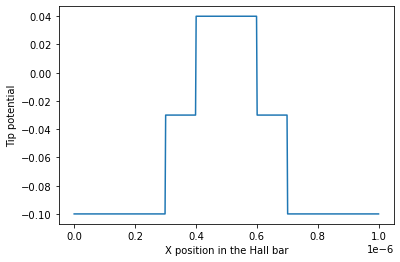

In [60]:

N=500;


plt.figure()
d=np.linspace(0,L,N)
potential =Vg*np.ones(N)


for i,X in enumerate(d):
     if (X > X_2 and X < L - X_2):
            potential[i]+=delta
            if (X > X_3 and X < L - X_3):
                potential[i]+=delta
                

        
plt.plot(d,potential)

plt.xlabel('X position in the Hall bar')
plt.ylabel('Tip potential')


#### Visualization of the LL + step potential

Vg =  -0.1
n 0 LL + pot = 0.1
n 0 LL + pot = 0.1
n 1 LL + pot = 0.21154116184204041
n -1 LL + pot = -0.011541161842040404
n 2 LL + pot = 0.2577430238398659
n -2 LL + pot = -0.057743023839865903
n 3 LL + pot = 0.293194959445677
n -3 LL + pot = -0.09319495944567693
n 4 LL + pot = 0.32308232368408085
n -4 LL + pot = -0.12308232368408081
Fermi Energy = -0.02


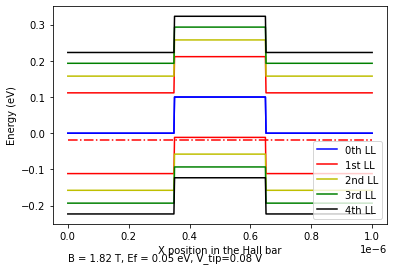

In [61]:


plt.figure()
d=np.linspace(0,L,N)

print('Vg = ',Vg)

LL_pot_plus = np.zeros(num_LL)
LL_pot_minus = np.zeros(num_LL)
En_plot_plus= np.zeros(num_LL)
En_plot_minus = np.zeros(num_LL)

for n in range(num_LL):
    
    """ 
    Change the definition of En to calculate the Landau levels energy as a function of
    the magnetic field Bfield and the Landau level label n
    
    """
    
    
    
    En_plus = 3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield) # to be completed
    En_minus = -3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield)
    
    LL_pot_plus[n]=En_plus-Vg
    LL_pot_minus[n]=En_minus-Vg
    En_plot_plus[n]=LL_pot_plus[n] + Vg
    En_plot_minus[n]=LL_pot_minus[n] + Vg
    
    En_plus_pot=np.zeros(N)
    En_minus_pot=np.zeros(N)
    
    print('n', n,  'LL + pot =', LL_pot_plus[n])
    print('n', -n, 'LL + pot =', LL_pot_minus[n])
    
    for i,X in enumerate(d):
        En_plus_pot[i] = En_plus
        En_minus_pot[i] = En_minus
        if (X > (L-l_pot)/2  and X< (L+l_pot)/2 ):
            En_plus_pot[i] = En_plus - Vg;
            En_minus_pot[i] = En_minus - Vg;
    
    if (n==0):
        plt.plot(d,En_plus_pot,'b', label = "0th LL") 
        plt.plot(d,En_minus_pot,'b')
    elif (n==1):
        plt.plot(d,En_plus_pot,'r', label = "1st LL")
        plt.plot(d,En_minus_pot,'r')
    elif (n==2):
        plt.plot(d,En_plus_pot,'y', label = "2nd LL")
        plt.plot(d,En_minus_pot,'y') 
    elif (n==3):
        plt.plot(d,En_plus_pot,'g', label = "3rd LL")
        plt.plot(d,En_minus_pot,'g')
    elif (n==4):
        plt.plot(d,En_plus_pot,'k', label = "4th LL")
        plt.plot(d,En_minus_pot,'k')
        
        
        
print ('Fermi Energy =',Ef)
    
plt.plot(d, Ef*np.ones(N), 'r-.') # to plot the Fermi energy (in red)

plt.xlabel('X position in the Hall bar')
plt.ylabel('Energy (eV)')

plt.text(0, -0.35, "B = 1.82 T, Ef = 0.05 eV, V_tip=0.08 V")

plt.legend(loc ="lower right")
plt.show()




#### Visualization of the LL + stairwell potential

LL n.  0
For X <  3e-07 and X >  7e-07 E = 0.1
For X <  4e-07 and X >  6e-07 E = 0.03
For X >  4e-07 and X <  6e-07 E = -0.04000000000000001
LL n.  0
For X <  3e-07 and X >  7e-07 E = 0.1
For X <  4e-07 and X >  6e-07 E = 0.03
For X >  4e-07 and X <  6e-07 E = -0.04000000000000001
LL n.  0
For X <  3e-07 and X >  7e-07 E = 0.1
For X <  4e-07 and X >  6e-07 E = 0.03
For X >  4e-07 and X <  6e-07 E = -0.04000000000000001
LL n.  1
For X <  3e-07 and X >  7e-07 E = 0.21154116184204041
For X <  4e-07 and X >  6e-07 E = 0.1415411618420404
For X >  4e-07 and X <  6e-07 E = 0.0715411618420404
LL n.  -1
For X <  3e-07 and X >  7e-07 E = -0.011541161842040404
For X <  4e-07 and X >  6e-07 E = -0.08154116184204041
For X >  4e-07 and X <  6e-07 E = -0.15154116184204042
LL n.  2
For X <  3e-07 and X >  7e-07 E = 0.2577430238398659
For X <  4e-07 and X >  6e-07 E = 0.1877430238398659
For X >  4e-07 and X <  6e-07 E = 0.1177430238398659
LL n.  -2
For X <  3e-07 and X >  7e-07 E = -0.05774302383986590

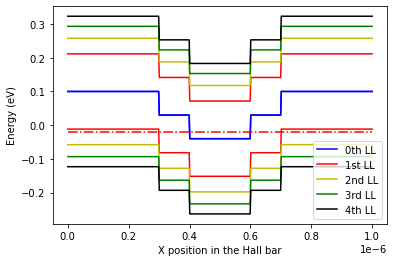

In [62]:

N=500;

modified_LL=np.zeros([9,3])        # The first index is the LL, the second the different well due to the stairwell potential

for n in range (num_LL):

     
    En_plus = 3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield) # to be completed
    En_minus = -3*t*a*np.sqrt(e/(2*h_reduced))*np.sqrt(n*Bfield)
    
    
    En_plus_pot= En_plus-potential
    En_minus_pot=En_minus-potential
    
    
    
    
    if (n==0):
        plt.plot(d,En_plus_pot,'b', label = "0th LL") 
        plt.plot(d,En_minus_pot,'b')
    elif (n==1):
        plt.plot(d,En_plus_pot,'r', label = "1st LL")
        plt.plot(d,En_minus_pot,'r')
    elif (n==2):
        plt.plot(d,En_plus_pot,'y', label = "2nd LL")
        plt.plot(d,En_minus_pot,'y') 
    elif (n==3):
        plt.plot(d,En_plus_pot,'g', label = "3rd LL")
        plt.plot(d,En_minus_pot,'g')
    elif (n==4):
        plt.plot(d,En_plus_pot,'k', label = "4th LL")
        plt.plot(d,En_minus_pot,'k')
        
    if (n==0):
        modified_LL[n,0]=En_plus-Vg
        modified_LL[n,1]=En_plus-Vg-delta
        modified_LL[n,2]=En_plus-Vg-2*delta
        
        print('LL n. ', n)
        print('For X < ',X_2, 'and X > ',L-X_2, 'E =', modified_LL[n,0])
        print('For X < ',X_3, 'and X > ',L-X_3, 'E =', modified_LL[n,1])
        print('For X > ',X_3, 'and X < ',L-X_3, 'E =', modified_LL[n,2])
    
    
    modified_LL[2*n-1,0]=En_plus-Vg
    modified_LL[2*n-1,1]=En_plus-Vg-delta
    modified_LL[2*n-1,2]=En_plus-Vg-2*delta
    
    modified_LL[2*n,0]=En_minus-Vg
    modified_LL[2*n,1]=En_minus-Vg-delta
    modified_LL[2*n,2]=En_minus-Vg-2*delta
    
    
    print('LL n. ', n)
    print('For X < ',X_2, 'and X > ',L-X_2, 'E =', modified_LL[2*n-1,0])
    print('For X < ',X_3, 'and X > ',L-X_3, 'E =', modified_LL[2*n-1,1])
    print('For X > ',X_3, 'and X < ',L-X_3, 'E =', modified_LL[2*n-1,2])
        
   
    print('LL n. ', -n)
    print('For X < ',X_2, 'and X > ',L-X_2, 'E =', modified_LL[2*n,0])
    print('For X < ',X_3, 'and X > ',L-X_3, 'E =', modified_LL[2*n,1])
    print('For X > ',X_3, 'and X < ',L-X_3, 'E =', modified_LL[2*n,2])
        
    
plt.plot(d, Ef*np.ones(N), 'r-.') 
print('Fermi energy = ',Ef)

plt.xlabel('X position in the Hall bar')
plt.ylabel('Energy (eV)')


plt.legend(loc ="lower right")
plt.show()
        


### Current and wf density

#### Wave function

In [63]:
wfs = kwant.wave_function(sys, energy=Ef, params = params ) # the wave function is obtained by giving the 
                                                    # parameters in arguments
scattering_wf = wfs(0) # all scattering wave functions from lead 0

print(scattering_wf)

[[ 6.64678785e-02+1.05570300e-01j  1.76269533e-02-2.44895350e-01j
  -2.33377853e-01+2.73940393e-01j ...  4.35246612e-11+1.79165755e-11j
  -5.01759406e-11-8.24785243e-11j -1.68422761e-11+1.92609592e-10j]]


#### Current density


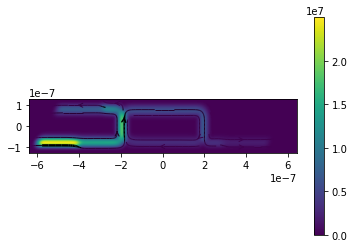

<ipython-input-64-5a435cfd63f1>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.current(sys, current, cmap='viridis')


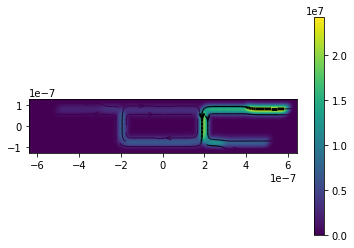

Disorder potential not activated


<ipython-input-64-5a435cfd63f1>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.current(sys, current_right, cmap='viridis')


In [64]:
## To obtain edge states, a strong field is required, in order to be in the high magnetic fiedl regime. 2 T gives edge states, 
## 0.1 T gives normal conduction

J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
wf_right=wfs(1)

#np.append(wf_left,wf_right)
current = sum(J0(p, params = params) for p in wf_left) # to sum over all the lead's mode


current_right=sum(J0(p, params = params) for p in wf_right)


#np.insert(current,1,current_right)


kwant.plotter.current(sys, current, cmap='viridis')





kwant.plotter.current(sys, current_right, cmap='viridis')


if(flag==1):
    print('Disorder potential activated')
else:
    print('Disorder potential not activated')

To have clear current plots ypu have to make sure the potential zone does not overlap with the leads 

### Plotting Hall conductance as function of the voltage applied (Fermi level)

In [43]:


print('The field is fixed and equal to ',Bfield)
print('The tip potential is the stairwell potential ')
Ef_min=-0.05
Ef_max=0.11
n_iter=100;

print('The Fermi energy will be shifted from' ,Ef_min, 'to', Ef_max )

Ef_arr=np.linspace(Ef_min,Ef_max,n_iter)

Rxx_Ef=np.zeros([len(Ef_arr),1])
Rxy_Ef=np.zeros([len(Ef_arr),1])

params=dict(Bfield=Bfield, Vg=Vg)

for i,Ef_xy in enumerate(Ef_arr):
        
    try:
        
        s=kwant.smatrix(sys, energy=Ef_xy, params=params)
        
        #conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(n)] for i in range(n)])
        
        cond -= np.diag(cond.sum(axis=0))
        
        cm = s.conductance_matrix()[:-1, :-1]
        
        Rxx = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        print('R hall=',Rxx[4])
        print('R long=',Rxx[3])
        
        Rxx_Ef[i] = Rxx[3]
        
        Rxy_Ef[i] = Rxx[4]
        
        print('iteration',i,'succeeded')
    except:
        print('problem encountered at iteration', i)
        
print(flag)

The field is fixed and equal to  1.82
The tip potential is the stairwell potential 
The Fermi energy will be shifted from -0.05 to 0.11
R hall= -0.9999537785091219
R long= 0.0025508656158922415
iteration 0 succeeded
R hall= -0.9999724191492719
R long= 0.0011287701780601086
iteration 1 succeeded
R hall= -0.9999927588614193
R long= 0.0003758406861043334
iteration 2 succeeded
R hall= -0.9999999748576961
R long= 6.065656591653885e-08
iteration 3 succeeded
R hall= -0.9999957551401559
R long= 0.00016151911464127816
iteration 4 succeeded
R hall= -0.999989987238714
R long= 0.0007714274063678815
iteration 5 succeeded
R hall= -0.9999909340852403
R long= 0.00028607138770653164
iteration 6 succeeded
R hall= -0.9999915807244448
R long= 0.00020609216982493393
iteration 7 succeeded
R hall= -0.999999976844417
R long= 5.269293013804937e-08
iteration 8 succeeded
R hall= -1.0000090540514643
R long= 0.0002531889932515061
iteration 9 succeeded
R hall= -1.0000030732881628
R long= 0.00010833772022517532
iter

R hall= 0.9999999999976961
R long= 1.1467027972530547e-05
iteration 102 succeeded
R hall= 0.9999999999990247
R long= 3.9441193391154345e-06
iteration 103 succeeded
R hall= 0.9999999999994859
R long= 1.031764540958225e-07
iteration 104 succeeded
R hall= 0.9999999999997053
R long= 2.9067366295424016e-06
iteration 105 succeeded
R hall= 0.9999999999998299
R long= 6.433926734805913e-07
iteration 106 succeeded
R hall= 0.9999999999998748
R long= 6.637146626676326e-07
iteration 107 succeeded
R hall= 0.9999999999999133
R long= 2.0010141777573096e-07
iteration 108 succeeded
R hall= 0.9999999999999415
R long= 3.7746910984542216e-07
iteration 109 succeeded
R hall= 0.9999999999999533
R long= 7.175761747441755e-10
iteration 110 succeeded
R hall= 0.9999999999999618
R long= 1.7435720411919054e-07
iteration 111 succeeded
R hall= 0.9999999999999692
R long= 6.993844503426964e-08
iteration 112 succeeded
R hall= 0.999999999999976
R long= 6.906591753863015e-09
iteration 113 succeeded
R hall= 0.9999999999999

With this interval of Fermi energy, one should have the following regimes:

In [44]:
Ef_1 = modified_LL[0,2]
Ef_2 = modified_LL[2,0]
Ef_3 = modified_LL[1,2]
Ef_4 = modified_LL[0,0]

print('For ',Ef_min, '< Ef < ', Ef_1, 'partial backscattering regime')
print('     v= -6          v=-2          v=-6')
print('For ',Ef_1, '< Ef < ', Ef_2, 'partial backscattering regime and full backscattering regime')
print('v= -6      v=-2     v=2   v=-2    v=-6')
print('For ',Ef_2, '< Ef < ', Ef_3, 'full backscattering regime')
print('     v= -2          v=2          v=-2')
print('For ',Ef_3, '< Ef < ', Ef_4, 'full backscattering regime and indirect backscattering regime')
print('v= -2      v=2     v=6   v=2    v=-2')
print('For ',Ef_4, '< Ef < ', Ef_max, 'indirect backscattering regime')
print('     v= 2          v=6          v=2')





For  -0.05 < Ef <  -0.04000000000000001 partial backscattering regime
     v= -6          v=-2          v=-6
For  -0.04000000000000001 < Ef <  -0.011541161842040404 partial backscattering regime and full backscattering regime
v= -6      v=-2     v=2   v=-2    v=-6
For  -0.011541161842040404 < Ef <  0.0715411618420404 full backscattering regime
     v= -2          v=2          v=-2
For  0.0715411618420404 < Ef <  0.1 full backscattering regime and indirect backscattering regime
v= -2      v=2     v=6   v=2    v=-2
For  0.1 < Ef <  0.11 indirect backscattering regime
     v= 2          v=6          v=2


### Plotting Hall conductance as function of the magnetic field

In [144]:
#Bmax=2*Ef**2*h_reduced/(9*t**2*a**2*e*1)
Bmin=0;
Bmax=3;                   ## Some Hall features are recovered looking at small foeld regions (Bmax = 1 T or less)
print('The magnetic field will be shifted from', Bmin, 'to', Bmax)
print('The Fermi energy will be constant and set to',Ef)
print('The tip potential is fixed and equal to ', Vg)


## With this method you keep E_f fixed and you sweep the field, so that the LL move.
## If one keeps the field fixed (and the LL) and sweeps Ef, it should be the same.

Bs=np.linspace(Bmin,Bmax,n_iter)

Rxx_B=np.zeros([len(Bs),1])
Rxy_B=np.zeros([len(Bs),1])

for i,Bfield in enumerate(Bs):
        
    try:
        params=dict(Bfield=Bfield, Vg=Vg)
        s=kwant.smatrix(sys, energy=Ef, params=params)
        
        #conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(n)] for i in range(n)])
        
        cond -= np.diag(cond.sum(axis=0))
        
        cm = s.conductance_matrix()[:-1, :-1]
        
        Rxx = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        
        print('R hall = ',Rxx[4])
        print('R long=',Rxx[3])
        Rxx_B[i] = Rxx[3]
        
        Rxy_B[i] = Rxx[4]
        
        print('iteration',i,'succeeded')
    except:
        print('problem encountered at iteration', i)
        


The magnetic field will be shifted from 0 to 5
The Fermi energy will be constant and set to 0.05
The tip potential is fixed and equal to  0
R hall =  -0.004153407430135079
R long= 0.1085842847139745
iteration 0 succeeded
R hall =  0.0062479231969500785
R long= 0.07946092232974349
iteration 1 succeeded
R hall =  0.028438140567541535
R long= 0.0681663801748769
iteration 2 succeeded
R hall =  0.09838772698842346
R long= 0.056661190918618605
iteration 3 succeeded
R hall =  0.16443578252392566
R long= 0.013132949611224718
iteration 4 succeeded
R hall =  0.16402824138166386
R long= 0.01336734828660512
iteration 5 succeeded
R hall =  0.3327151097519387
R long= 0.0002971834442287656
iteration 6 succeeded
R hall =  0.33331574684105103
R long= 2.809263747970866e-06
iteration 7 succeeded
R hall =  0.33333148678467267
R long= 4.803417856295064e-08
iteration 8 succeeded
R hall =  0.33333328529957196
R long= 2.166295509590459e-08
iteration 9 succeeded
R hall =  0.3333333127527134
R long= 1.549531503

### Plotting Hall conductivity as function of local potential (tip potential)

In [24]:
print('The field is fixed and equal to', Bfield)
print('The Fermi level is fixed and equal to', Ef)

Vg_min=-0.17
Vg_max=0.09
n_iter_Vg=100;
print('We will shift the tip potential from', Vg_min, 'to', Vg_max)
print('We should have crossing with the first positive and negative LL and 0th LL')

Vg_arr=np.linspace(Vg_min,Vg_max,n_iter_Vg)
Rxx_Vg=np.zeros([len(Vg_arr),1])
Rxy_Vg=np.zeros([len(Vg_arr),1])


for i,Vg in enumerate(Vg_arr):
        
    try:
        params=dict(Bfield=Bfield, Vg=Vg)
        s=kwant.smatrix(sys, energy=Ef, params=params)
        
        #conductance matrix from the transmission matrix
        cond = np.array([[s.transmission(i, j) for j in range(n)] for i in range(n)])
        
        cond -= np.diag(cond.sum(axis=0))
        
        cm = s.conductance_matrix()[:-1, :-1]
        
        Rxx = np.linalg.solve(cm, [1, -1, 0, 0, 0])
        
        print('R hall = ',Rxx[4])
        print('R long=',Rxx[3])
        Rxx_Vg[i] = Rxx[3]
        
        Rxy_Vg[i] = Rxx[4]
        
        print('iteration',i,'succeeded')
    except:
        print('problem encountered at iteration', i)

print(flag)

The field is fixed and equal to 1.8285678225446869
The Fermi level is fixed and equal to 0.05
We will shift the tip potential from -0.17 to 0.09
We should have crossing with the first positive and negative LL and 0th LL
R hall =  0.9999377734235415
R long= 0.04097594539864659
iteration 0 succeeded
R hall =  0.99999271477691
R long= 0.006852512466891987
iteration 1 succeeded
R hall =  0.9999970624832337
R long= 0.03008640600079851
iteration 2 succeeded
R hall =  0.9998781879959031
R long= 0.6073181553531658
iteration 3 succeeded
R hall =  0.9999810200996601
R long= 0.07740691673985252
iteration 4 succeeded
R hall =  0.9999681484071125
R long= 0.20982922618962763
iteration 5 succeeded
R hall =  0.9999942887227088
R long= 0.0001495919861548452
iteration 6 succeeded
R hall =  0.999988316597302
R long= 0.0024244735151776995
iteration 7 succeeded
R hall =  0.9999723012801197
R long= 0.02308151586504631
iteration 8 succeeded
R hall =  0.9999861768776408
R long= 0.46465216197185305
iteration 9

R hall =  0.9999755357138784
R long= 0.022907593594967978
iteration 100 succeeded
R hall =  0.9995149365940166
R long= 0.04813710134185715
iteration 101 succeeded
R hall =  0.999978661571599
R long= 0.0018843947145694203
iteration 102 succeeded
R hall =  0.9999502434394244
R long= 0.40497124113092564
iteration 103 succeeded
R hall =  0.9998646569291259
R long= 0.0003608859629536788
iteration 104 succeeded
R hall =  0.9999944813324655
R long= 0.11995445186236926
iteration 105 succeeded
R hall =  0.9999289441336981
R long= 0.03001567392385789
iteration 106 succeeded
R hall =  0.9999666029634398
R long= 0.13303230562705914
iteration 107 succeeded
R hall =  0.9999405099701638
R long= 0.13520989596030294
iteration 108 succeeded
R hall =  0.9998909156624086
R long= 0.08751745147762797
iteration 109 succeeded
R hall =  0.9999118932243453
R long= 0.051429524625211935
iteration 110 succeeded
R hall =  0.999404804521501
R long= 8.753642026212566
iteration 111 succeeded
R hall =  0.99997325534011

R hall =  0.9999998473537415
R long= 3.531435908563551e-06
iteration 201 succeeded
R hall =  0.9999984465005782
R long= 0.00040829040821314667
iteration 202 succeeded
R hall =  0.9999931954786097
R long= 0.0004527739132166602
iteration 203 succeeded
R hall =  0.9999968859232314
R long= 0.007677472294336371
iteration 204 succeeded
R hall =  0.9999967775781248
R long= 0.08486543613720501
iteration 205 succeeded
R hall =  0.9999998675959338
R long= 0.013164931876581876
iteration 206 succeeded
R hall =  0.9999995935642042
R long= 0.012973656867756922
iteration 207 succeeded
R hall =  0.999998897605641
R long= 0.0018162935698662099
iteration 208 succeeded
R hall =  0.9999981422350172
R long= 0.010460802701672454
iteration 209 succeeded
R hall =  0.9985560483292977
R long= 3.3139427321018182
iteration 210 succeeded
R hall =  0.9999928764182379
R long= 0.01923700707336913
iteration 211 succeeded
R hall =  0.9999945710057627
R long= 0.0007428273961483372
iteration 212 succeeded
R hall =  0.999

R hall =  0.9999878933386328
R long= 0.017436181803726022
iteration 302 succeeded
R hall =  0.9998869688136852
R long= 0.00024735758081442425
iteration 303 succeeded
R hall =  0.9998927128976071
R long= -1.7694215634682602e-05
iteration 304 succeeded
R hall =  0.9987944937333386
R long= 0.22201831562946342
iteration 305 succeeded
R hall =  0.9999802330038584
R long= 0.0428583074539617
iteration 306 succeeded
R hall =  0.999997086950763
R long= 0.004276301300204148
iteration 307 succeeded
R hall =  0.9999910009131111
R long= 0.01566545293373745
iteration 308 succeeded
R hall =  0.9999917964880584
R long= 0.018283560334738137
iteration 309 succeeded
R hall =  0.9999972531520658
R long= 0.0005010680564028766
iteration 310 succeeded
R hall =  0.9999967782329193
R long= 0.0004407019739318831
iteration 311 succeeded
R hall =  0.9999937833799731
R long= 7.612375299881426e-05
iteration 312 succeeded
R hall =  0.9999723493025889
R long= 0.03268668022778281
iteration 313 succeeded
R hall =  0.99

R hall =  0.9999992405118897
R long= 0.0020438522927029136
iteration 403 succeeded
R hall =  0.9999987332983301
R long= 0.0006542528776670706
iteration 404 succeeded
R hall =  0.9999971520929172
R long= 0.0023779303288424124
iteration 405 succeeded
R hall =  0.9999536614428371
R long= 0.06193432807157332
iteration 406 succeeded
R hall =  0.9999971644420508
R long= 0.007457866992848076
iteration 407 succeeded
R hall =  0.9999996022182597
R long= 0.0010881146721047547
iteration 408 succeeded
R hall =  0.999981107727284
R long= 0.013007336418587553
iteration 409 succeeded
R hall =  0.9999988194576838
R long= 8.465019898348638e-05
iteration 410 succeeded
R hall =  0.9999849728266954
R long= 2.1193608752072976e-05
iteration 411 succeeded
R hall =  0.9999949157340782
R long= 0.02039666549587261
iteration 412 succeeded
R hall =  0.9999692974702424
R long= 0.05858245379699785
iteration 413 succeeded
R hall =  0.9999987211828748
R long= 0.0025709839403168394
iteration 414 succeeded
R hall =  0.

R hall =  0.9999977518908499
R long= 0.0009870614839302828
iteration 504 succeeded
R hall =  0.9999988247607877
R long= 0.0004897557463407564
iteration 505 succeeded
R hall =  0.9999992493428623
R long= 0.00029807397355302074
iteration 506 succeeded
R hall =  0.999999446417773
R long= 0.00021182399042153055
iteration 507 succeeded
R hall =  0.9999995365639808
R long= 0.00017483922291601717
iteration 508 succeeded
R hall =  0.9999995538816734
R long= 0.0001736031387704953
iteration 509 succeeded
R hall =  0.9999994700034062
R long= 0.00023446883074058138
iteration 510 succeeded
R hall =  0.999998853460033
R long= 0.0007598825450022176
iteration 511 succeeded
R hall =  0.9999999594275895
R long= 0.0007104249292495893
iteration 512 succeeded
R hall =  0.9999994364966833
R long= 9.575708645155308e-06
iteration 513 succeeded
R hall =  0.9999725362857931
R long= 0.004284333047503529
iteration 514 succeeded
R hall =  0.9999998249224936
R long= 7.330310878876859e-05
iteration 515 succeeded
R h

R hall =  0.9999999999999599
R long= 1.9685464046488068e-11
iteration 603 succeeded
R hall =  0.9999999999999739
R long= 1.3596374396849155e-11
iteration 604 succeeded
R hall =  0.9999999999999766
R long= 8.952584648340391e-12
iteration 605 succeeded
R hall =  0.9999999999999789
R long= 5.3122019522245466e-12
iteration 606 succeeded
R hall =  0.9999999999999833
R long= 2.6464513649418265e-12
iteration 607 succeeded
R hall =  0.9999999999999849
R long= 9.446322660988182e-13
iteration 608 succeeded
R hall =  0.9999999999999897
R long= 1.2519472683621704e-13
iteration 609 succeeded
R hall =  0.9999999999999826
R long= 3.50797199722102e-14
iteration 610 succeeded
R hall =  0.9999999999999892
R long= 4.823292535286831e-13
iteration 611 succeeded
R hall =  0.9999999999999879
R long= 1.2600564038183086e-12
iteration 612 succeeded
R hall =  0.9999999999999982
R long= 2.179824939079046e-12
iteration 613 succeeded
R hall =  0.999999999999991
R long= 3.0811788189022274e-12
iteration 614 succeeded

R hall =  0.9999999999999997
R long= 1.2029091705772629e-11
iteration 702 succeeded
R hall =  0.9999999999999976
R long= 1.1741216344191569e-11
iteration 703 succeeded
R hall =  0.9999999999999972
R long= 1.0742919540922662e-11
iteration 704 succeeded
R hall =  0.9999999999999967
R long= 9.07767039558547e-12
iteration 705 succeeded
R hall =  1.0000000000000016
R long= 6.900359172817956e-12
iteration 706 succeeded
R hall =  1.0000000000000036
R long= 4.479294037857082e-12
iteration 707 succeeded
R hall =  1.0000000000000013
R long= 2.198339388841436e-12
iteration 708 succeeded
R hall =  1.0000000000000073
R long= 5.342856081118427e-13
iteration 709 succeeded
R hall =  0.9999999999999996
R long= 1.6720589583117315e-14
iteration 710 succeeded
R hall =  0.999999999999996
R long= 1.1817982480825375e-12
iteration 711 succeeded
R hall =  0.9999999999999959
R long= 4.497099959824468e-12
iteration 712 succeeded
R hall =  0.9999999999999976
R long= 1.0290456118553659e-11
iteration 713 succeeded


R hall =  0.9999999999998654
R long= 1.7765662974098685e-07
iteration 801 succeeded
R hall =  0.9999999999998553
R long= 1.9425026618627906e-07
iteration 802 succeeded
R hall =  0.9999999999998417
R long= 1.84182251437237e-07
iteration 803 succeeded
R hall =  0.999999999999823
R long= 1.4631126750000845e-07
iteration 804 succeeded
R hall =  0.9999999999998124
R long= 8.91512380303754e-08
iteration 805 succeeded
R hall =  0.9999999999997908
R long= 3.167920376197598e-08
iteration 806 succeeded
R hall =  0.9999999999997643
R long= 6.110776210436855e-10
iteration 807 succeeded
R hall =  0.9999999999997355
R long= 2.3505881094056286e-08
iteration 808 succeeded
R hall =  0.9999999999997075
R long= 1.1841950931687838e-07
iteration 809 succeeded
R hall =  0.9999999999996851
R long= 2.826844833973623e-07
iteration 810 succeeded
R hall =  0.999999999999664
R long= 4.852304468494443e-07
iteration 811 succeeded
R hall =  0.9999999999996418
R long= 6.678088714579463e-07
iteration 812 succeeded
R h

R hall =  0.9999803395762769
R long= 5.765565317685727
iteration 902 succeeded
R hall =  0.999980613598695
R long= 8.992551559832298
iteration 903 succeeded
R hall =  0.9999808225902773
R long= 11.733805189474703
iteration 904 succeeded
R hall =  0.9999809784145647
R long= 13.483446556894481
iteration 905 succeeded
R hall =  0.9999810899149268
R long= 13.957882720344834
iteration 906 succeeded
R hall =  0.9999811635377015
R long= 13.117504191365224
iteration 907 succeeded
R hall =  0.9999812043823243
R long= 11.152157709989682
iteration 908 succeeded
R hall =  0.999981216334643
R long= 8.436289022234194
iteration 909 succeeded
R hall =  0.9999811988004493
R long= 5.462044864815126
iteration 910 succeeded
R hall =  0.9999811244259114
R long= 2.760085799284975
iteration 911 succeeded
R hall =  0.9999807958041095
R long= 0.8184337121100256
iteration 912 succeeded
R hall =  0.9999794968344251
R long= 0.009385999959935488
iteration 913 succeeded
R hall =  0.9999786625127892
R long= 0.533345

With these values of Vg, one should have crossing of the modified LL for these values of tip potential:

In [ ]:
Vg_minus_1 = En_plot_minus[1]-Ef
Vg_0 = En_plot_plus[0]-Ef
Vg_plus_1 = En_plot_plus[1] - Ef

print('Vg = ', Vg_minus_1, 'for the -1 LL')
print('Vg = ', Vg_0, 'for the 0th LL')
print('Vg = ', Vg_plus_1, 'for the 1st LL')

Since the longitudinal resistance changes depending on how many edge states are bakcscattered, these should be the values for which peaks in the longitudinal resistance should appear

#### Hall resistivity vs magnetic field

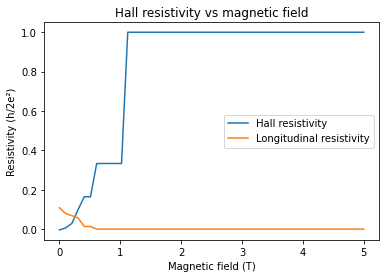

In [145]:

plt.figure()
plt.plot(Bs, Rxy_B, label = 'Hall resistivity')
plt.plot(Bs, Rxx_B, label = 'Longitudinal resistivity')
plt.legend()

plt.xlabel('Magnetic field (T)')
plt.ylabel('Resistivity (h/2e²)')
plt.title("Hall resistivity vs magnetic field")

plt.show()

#### Hall resistivity vs Fermi Energy

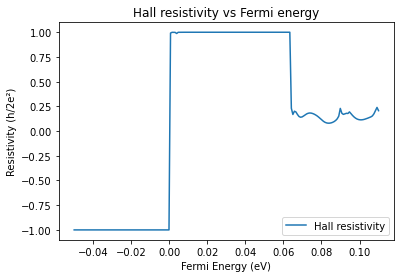

In [45]:

plt.figure()
plt.plot(Ef_arr, Rxy_Ef, label = 'Hall resistivity')
plt.legend()

plt.xlabel('Fermi Energy (eV)')
plt.ylabel('Resistivity (h/2e²)')
plt.title("Hall resistivity vs Fermi energy")

plt.show()

#### Longitudinal resistivity vs Fermi energy (with non-zero tip potential)

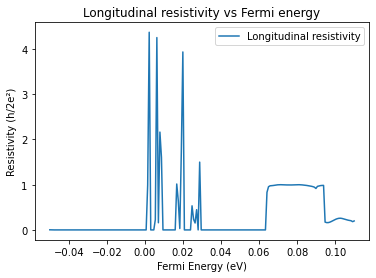

In [47]:
indices=np.where(Rxx_Ef > 10)
Rxx_Ef[indices]=0

plt.figure()
plt.plot(Ef_arr, Rxx_Ef, label = 'Longitudinal resistivity')
plt.legend()

plt.xlabel('Fermi Energy (eV)')
plt.ylabel('Resistivity (h/2e²)')
plt.title("Longitudinal resistivity vs Fermi energy")

plt.show()

#### Hall resistivity vs tip potential

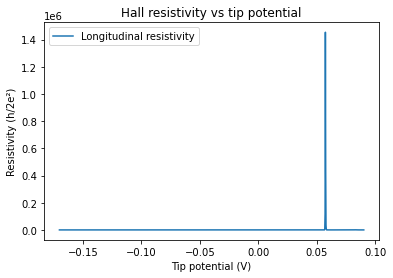

In [26]:
plt.figure()
#plt.plot(Vg_arr, Rxy_Vg, label = 'Hall resistivity')
plt.plot(Vg_arr,Rxx_Vg, label = 'Longitudinal resistivity')

plt.legend()

plt.xlabel('Tip potential (V)')
plt.ylabel('Resistivity (h/2e²)')
#plt.text(-0.1, 0.98, "B = 10 T, Ef = 0.05 eV")
plt.title("Hall resistivity vs tip potential")

#plt.axvline(Vg_minus_1, color = 'green')
#plt.axvline(Vg_0, color = 'green')
#plt.axvline(Vg_plus_1, color = 'green')

plt.show()

It seems like the transitions in the Hall resistance occur when Ef = LL at the edges, so R hall should not be influenced by the swiping of the potential. For these values of Ef and B, Rhall=1 (see figure Rh vs B) which is indeed what we get

About the longitudinal resistance, a small peak is observed for Vg_minus_1 (crossing with LL -1), no peak is observed for Vg_0 (crossing with 0th LL) and a series of peaks is observed in the surroundings of Vg_plus_1 (crossing with first LL) anyway I cannot explain the other peaks in this region. No peak is observed for Vg_0 since for the interval Vg_0 < V < Vg_plus_1 you have the same filling factor all the device. 

#### Conductivity vs magnetic field

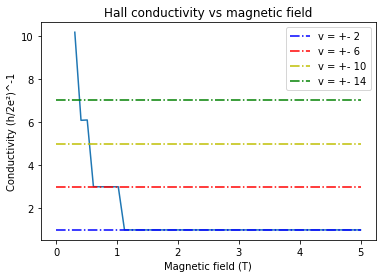

In [188]:


plt.figure()

G_xy_B=np.power(Rxy_B,-1)
plt.plot(Bs[3:],G_xy_B[3:])


G_j=np.zeros(len(Ef_arr))
for j in range (1,11,2):
    G_j=j*np.ones(len(Ef_arr))
    if (j==1):
        plt.plot(Bs,G_j,'b-.', label ="v = +- 2")
    elif(j==3):
        plt.plot(Bs,G_j,'r-.', label="v = +- 6")
    elif(j==5):
        plt.plot(Bs,G_j,'y-.',  label = "v = +- 10")
    elif(j==7):
        plt.plot(Bs,G_j,'g-.',  label = "v = +- 14")
  
    


plt.xlabel('Magnetic field (T)')
plt.ylabel('Conductivity (h/2e²)^-1')
plt.title("Hall conductivity vs magnetic field")
#plt.text(2, 10, "Ef = 0.05 eV, Vg = 0 V")
plt.legend(loc ="upper right")

plt.show()


Since the conductivity is defined in units of hbar/2e^2 the values of the filling factors which can be retrieved from the plot have to be multiplied by 2. Therefore one gets the usual succession of filling factors in graphene so 2,6,10 etc. with the spins and valley degeneracy, evein if the spin has not been explicitly considered in the calculations. The step for v=14 is anyway missing (crossing of third LL, n=3).

#### Conductivity vs Fermi energy

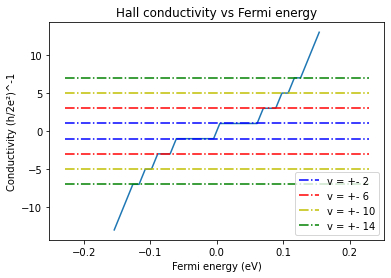

In [189]:

plt.figure()

G_xy_Ef=np.power(Rxy_Ef,-1)
plt.plot(Ef_arr[8:42],G_xy_Ef[8:42])


G_j=np.zeros(len(Ef_arr))
for j in range (1,11,2):
    G_plus_j=j*np.ones(len(Ef_arr))
    G_minus_j=-j*np.ones(len(Ef_arr))
    if (j==1):
         plt.plot(Ef_arr,G_plus_j,'b-.', label="v = +- 2")
         plt.plot(Ef_arr,G_minus_j,'b-.')
    elif(j==3):
        plt.plot(Ef_arr,G_plus_j,'r-.', label="v = +- 6")
        plt.plot(Ef_arr,G_minus_j,'r-.')
    elif(j==5):
        plt.plot(Ef_arr,G_plus_j,'y-.', label = "v = +- 10")
        plt.plot(Ef_arr,G_minus_j,'y-.')
    elif(j==7):
        plt.plot(Ef_arr,G_plus_j,'g-.', label = "v = +- 14")
        plt.plot(Ef_arr,G_minus_j,'g-.')
    
    
#print(Rxy_Ef)
#print(G_xy_Ef)

#for i in range (num_LL):
#    plt.axvline(LL_pot_plus[i],color = 'green',linestyle = '-.')
#    plt.axvline(LL_pot_minus[i],color = 'green',linestyle = '-.')
#    plt.axvline(En_plus[i],color = 'black',linestyle = '-.')
#    plt.axvline(En_minus[i], color = 'black',linestyle = '-.')





plt.xlabel('Fermi energy (eV)')
plt.ylabel('Conductivity (h/2e²)^-1')
plt.title("Hall conductivity vs Fermi energy")
#plt.text(-0.3, 15, "B = 1.82 T, Vg = 0 V")
plt.legend(loc ="lower right")

plt.show()

#### Longitudinal conductivity vs tip potential

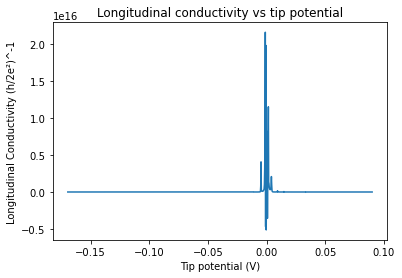

In [25]:

plt.figure()

G_xx_Vg=np.power(Rxx_Vg,-1)
plt.plot(Vg_arr[2:],G_xx_Vg[2:])


plt.xlabel('Tip potential (V)')
plt.ylabel('Longitudinal Conductivity (h/2e²)^-1')
#plt.text(0.05, 1.015, "B = 10 T, Ef = 0.05 eV")
plt.title("Longitudinal conductivity vs tip potential")

plt.show()

In this case clear steps of 2G0 are observed also for high filling factors but I don't really know to which transition they can be associated, since theoretically we have defined just 5 LL. Anyway, sweeping the gate voltage with opposite signs, the same fearures are obtained but with opposite signs, associated to the holes LL.

In [49]:
#print(Vg_arr)
print (Ef_arr[46])

-0.0861641170126248


### Open issues
#### - 2G0 steps (?)
#### - Longitudinal resistivity null
#### - Plateaus associated with transitions out of the 5 LL defined

In [43]:
np.where(Rxx_Vg < 1e-08)
print(Rxx_Vg[59])
print(Vg_arr[59])


[9.58921966e-08]
-0.015050505050505064


In [22]:
print(current)
print(current_right)

[-2.95608398e-02  1.66912204e-08  2.95608231e-02 ... -4.07359647e-11
  2.62241490e-03 -2.16840434e-17]
[-3.17159304e-03  1.79039298e-09  3.17159125e-03 ... -4.02644699e-10
  2.60325825e-02  1.30104261e-16]
